### American Sign Language Detection
##### Author: Badri Narayanan Ramesh (bramesh@usc.edu)

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,  precision_score, recall_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Found 87000 files belonging to 29 classes.
Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 659ms/step - accuracy: 0.0814 - loss: 5.7476 - val_accuracy: 0.1797 - val_loss: 5.2304
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 686ms/step - accuracy: 0.3066 - loss: 4.7755 - val_accuracy: 0.5000 - val_loss: 3.9537
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 629ms/step - accuracy: 0.5152 - loss: 3.8500 - val_accuracy: 0.5938 - val_loss: 3.3770
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 619ms/step - accuracy: 0.6249 - loss: 3.2185 - val_accuracy: 0.6615 - val_loss: 3.1756
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 623ms/step - accuracy: 0.7326 - loss: 2.8795 - val_accuracy: 0.7083 - val_loss: 2.8236
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 671ms/step - accuracy: 0.8176 - loss: 2.5700 - val_accuracy: 0.7396 - val_loss: 2.6109
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 595ms/step - accuracy: 0.8204 - loss: 2.4496 - val_accuracy: 0.7135 - val_loss: 2.6076
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 584ms/step -

Model has been saved as Keras .h5 file to asl_mobilenet_classifier_20241215_014404.h5


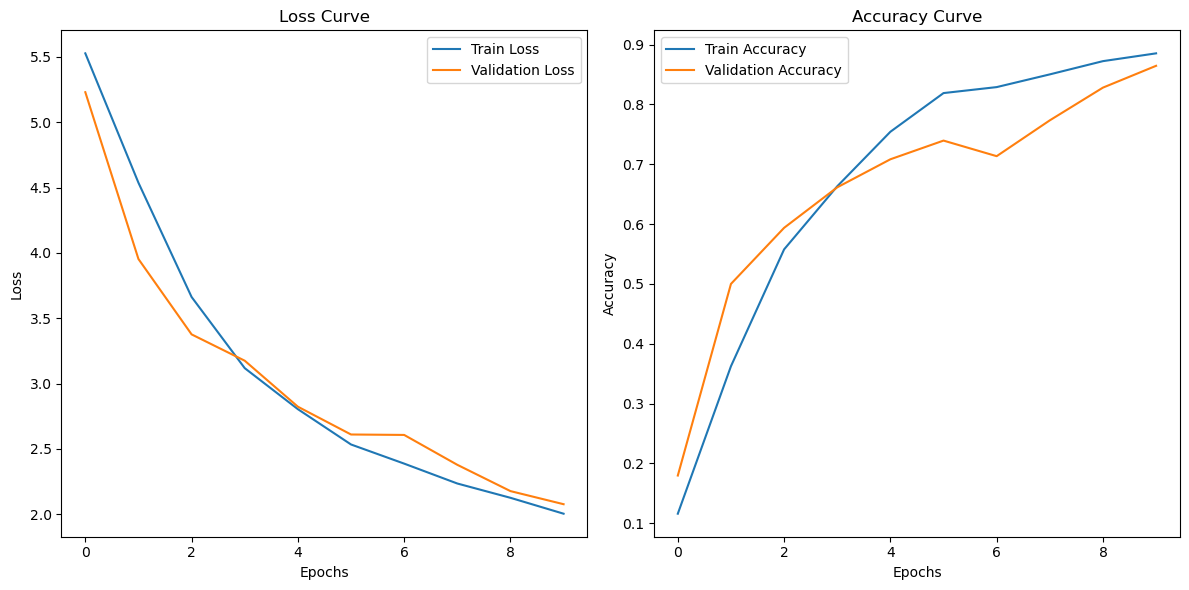

In [8]:
# Dataset path and parameters
data_dir = r"C:\Users\badri\Downloads\DL Projedct\fresh2\Main files\Deep-Learning-for-American-Sign-Language-Detection-ASL-\TensorFlow ASL with Gradio\archive\asl_alphabet_train\asl_alphabet_train"
test_data_dir = r"C:\Users\badri\Downloads\DL Projedct\fresh2\Main files\Deep-Learning-for-American-Sign-Language-Detection-ASL-\TensorFlow ASL with Gradio\archive\asl_alphabet_test\asl_alphabet_test"
augmented_test_dir = r"C:\Users\badri\Downloads\DL Projedct\fresh2\Main files\Deep-Learning-for-American-Sign-Language-Detection-ASL-\TensorFlow ASL with Gradio\augmented_test"
image_size = (224, 224)
batch_size = 32

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

# Dataset size and split
dataset_size = dataset.cardinality().numpy()
train_size = int(0.85 * dataset_size)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Data Augmentation and preprocessing
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

def preprocess_train_data(image, label):
    image = image / 255.0  # Normalize to [0, 1]
    image = data_augmentation(image)  # Apply augmentation
    return image, label

def preprocess_val_data(image, label):
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

train_dataset = train_dataset.map(preprocess_train_data).cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.map(preprocess_val_data).cache().prefetch(buffer_size=AUTOTUNE)

# Define Model - MobileNetV2 with L2 regularization and Dropout
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze last few layers for fine-tuning

for layer in base_model.layers[:-50]:
    if isinstance(layer, layers.Conv2D):
        layer.kernel_regularizer = regularizers.l2(0.01)  # Add L2 regularization
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(len(dataset.class_names), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training configuration
steps_per_epoch = train_size // batch_size
validation_steps = (dataset_size - train_size) // batch_size

# Training the model
history = model.fit(
    train_dataset,
    epochs=10,  # Increased epochs for better convergence
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# Save the model in .h5 format and .keras format
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
h5_model_path = f"asl_mobilenet_classifier_{timestamp}.h5"
model.save(h5_model_path, save_format='h5')
model.save(f"asl_mobilenet_classifier_{timestamp}.keras")

print(f"Model has been saved as Keras .h5 file to {h5_model_path}")

# Plot the training history (Loss and Accuracy)
plt.figure(figsize=(12, 6))

# Plot Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Plot Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.show()


Image: A_test.jpg, Predicted: A (Confidence: 73.51%), Actual: A
Image: B_test.jpg, Predicted: B (Confidence: 67.19%), Actual: B
Image: C_test.jpg, Predicted: C (Confidence: 99.90%), Actual: C
Image: del_test.jpg, Predicted: del (Confidence: 99.78%), Actual: del
Image: D_test.jpg, Predicted: D (Confidence: 98.59%), Actual: D
Image: E_test.jpg, Predicted: E (Confidence: 97.64%), Actual: E
Image: F_test.jpg, Predicted: F (Confidence: 99.95%), Actual: F
Image: G_test.jpg, Predicted: G (Confidence: 84.20%), Actual: G
Image: H_test.jpg, Predicted: H (Confidence: 78.05%), Actual: H
Image: I_test.jpg, Predicted: I (Confidence: 90.85%), Actual: I
Image: J_test.jpg, Predicted: J (Confidence: 92.79%), Actual: J
Image: K_test.jpg, Predicted: K (Confidence: 87.94%), Actual: K
Image: L_test.jpg, Predicted: L (Confidence: 57.00%), Actual: L
Image: M_test.jpg, Predicted: M (Confidence: 45.23%), Actual: M
Image: nothing_test.jpg, Predicted: nothing (Confidence: 67.10%), Actual: nothing
Image: N_test.jp

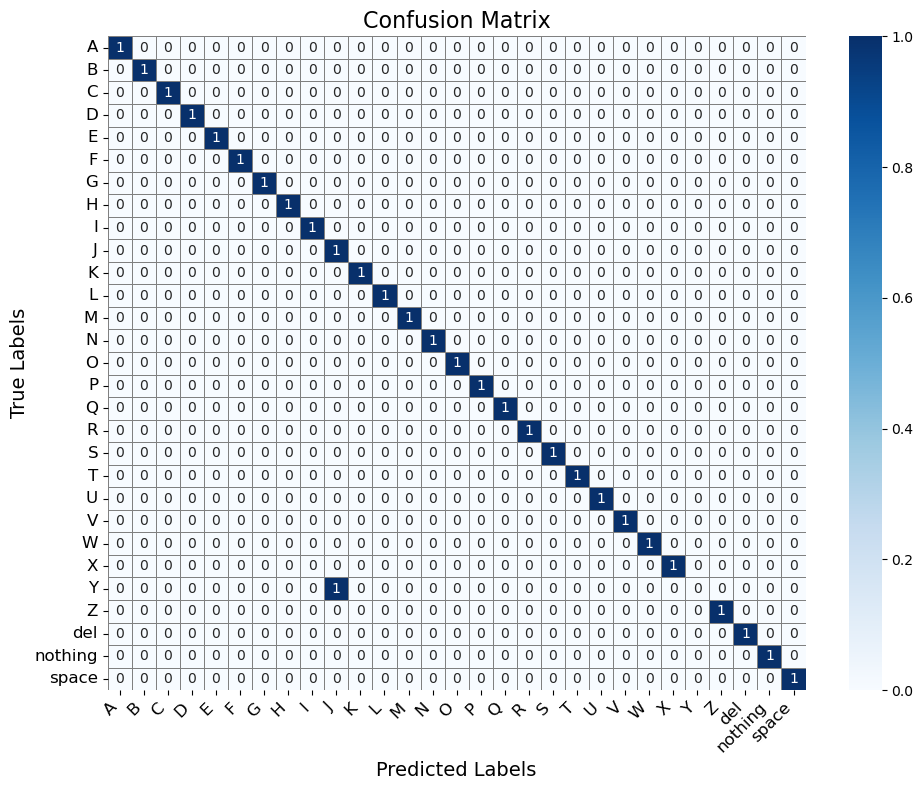

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       0.50      1.00      0.67         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00         1
    

c:\Users\badri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\badri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\badri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\badri\anaconda3\Lib\site-packag

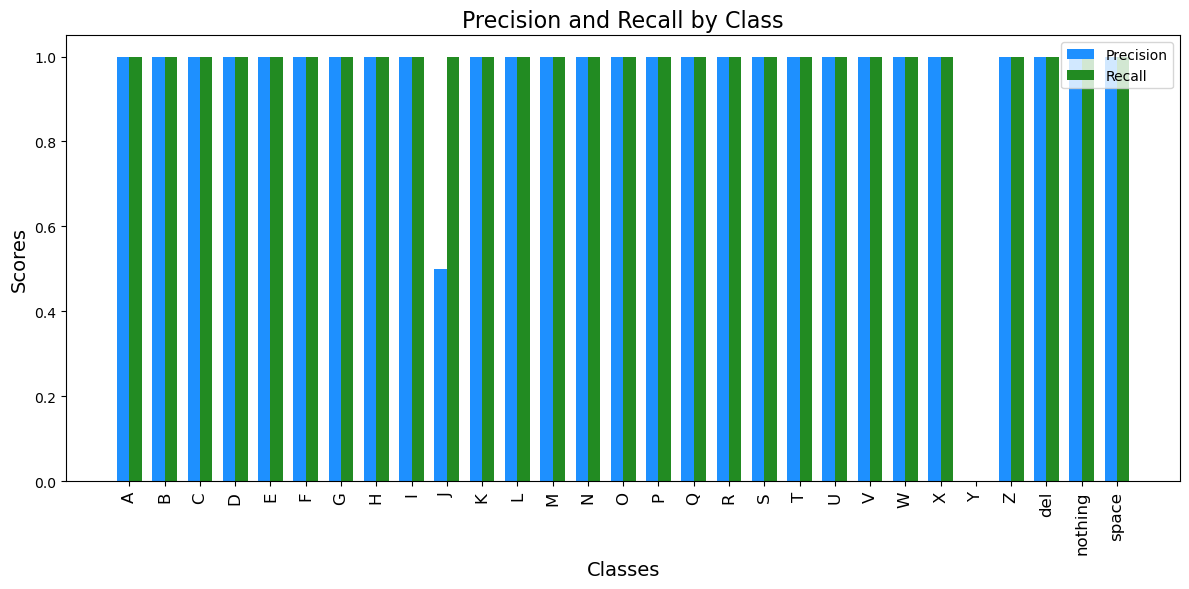

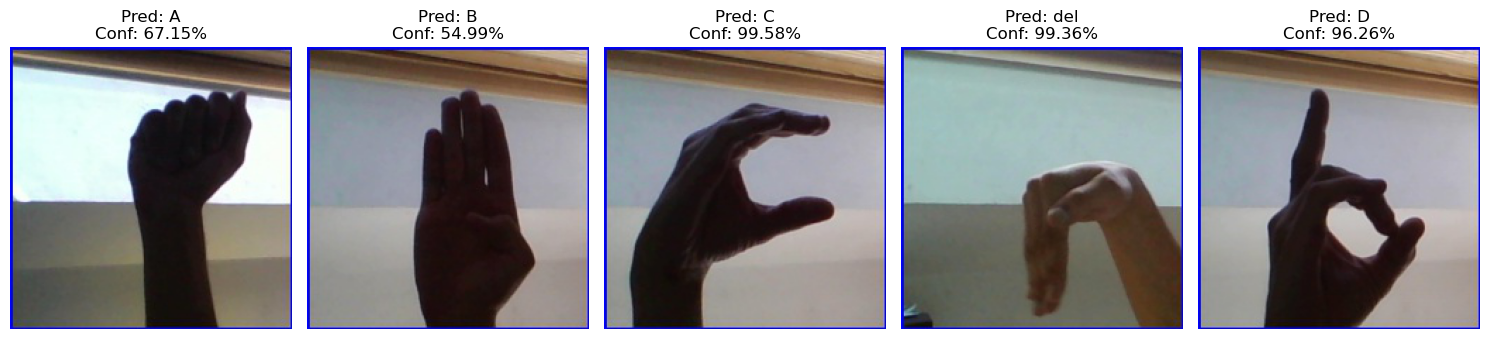

In [9]:
# Test-Time Augmentation (TTA) function
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Apply test-time augmentation (TTA) and predict
def predict_image_with_tta(image_path, model, test_datagen, class_names):
    img_array = load_and_preprocess_image(image_path)
    augmented_predictions = []

    # Generate augmented versions of the image
    for batch in test_datagen.flow(img_array, batch_size=1):
        pred = model.predict(batch, verbose=0)
        augmented_predictions.append(pred)
        if len(augmented_predictions) >= 5:  # Use 5 augmentations
            break

    # Average the predictions across augmented samples
    final_prediction = np.mean(augmented_predictions, axis=0)
    predicted_class = class_names[np.argmax(final_prediction)]
    confidence = np.max(final_prediction) * 100
    return predicted_class, confidence

# Create augmented test images directory if it does not exist
os.makedirs(augmented_test_dir, exist_ok=True)

# Data augmentation for test images
test_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Evaluate predictions on original test images
class_names = dataset.class_names
test_images = [f for f in os.listdir(test_data_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

y_true = []
y_pred = []

for image_name in test_images:
    image_path = os.path.join(test_data_dir, image_name)
    predicted_class, confidence = predict_image_with_tta(image_path, model, test_datagen, class_names)

    # Assume that the image name is in the format 'A_test.jpg', 'B_test.jpg', etc.
    actual_class = image_name.split('_')[0]  # Get the actual class from the file name

    print(f"Image: {image_name}, Predicted: {predicted_class} (Confidence: {confidence:.2f}%), Actual: {actual_class}")

    # Collect true and predicted labels for evaluation
    y_true.append(class_names.index(actual_class))
    y_pred.append(class_names.index(predicted_class))

# Ensure that the predictions and true labels are within the valid range of class indices
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check the unique values of y_true and y_pred to ensure no mismatch
print(f"Unique true labels: {np.unique(y_true)}")
print(f"Unique predicted labels: {np.unique(y_pred)}")

# Generate and display confusion matrix with formal color scheme
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
            cbar=True, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# Classification report with explicit labels
report = classification_report(y_true, y_pred, target_names=class_names, labels=np.arange(len(class_names)))
print("Classification Report:")
print(report)

# Precision and Recall by class
def precision_recall_by_class(y_true, y_pred, class_names):
    print("Precision and Recall by class:")
    
    precision_scores = []
    recall_scores = []
    
    for i, class_name in enumerate(class_names):
        precision = precision_score(y_true, y_pred, labels=[i], average='macro')
        recall = recall_score(y_true, y_pred, labels=[i], average='macro')
        precision_scores.append(precision)
        recall_scores.append(recall)
        print(f"Class: {class_name}")
        print(f"    Precision: {precision:.2f}")
        print(f"    Recall: {recall:.2f}")
        print("-" * 30)
    
    # Plotting Precision and Recall by Class with formal colors
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(class_names))

    # Using professional, subtle colors for the bars
    bar1 = ax.bar(index, precision_scores, bar_width, label='Precision', color='dodgerblue')
    bar2 = ax.bar(index + bar_width, recall_scores, bar_width, label='Recall', color='forestgreen')

    ax.set_xlabel('Classes', fontsize=14)
    ax.set_ylabel('Scores', fontsize=14)
    ax.set_title('Precision and Recall by Class', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(class_names, rotation=90, fontsize=12)
    ax.legend()

    plt.tight_layout()
    plt.show()

precision_recall_by_class(y_true, y_pred, class_names)

# Visualize predictions
def visualize_predictions(test_images_dir, model, num_images=5):
    test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = test_images[:num_images]

    plt.figure(figsize=(15, 8))
    for i, image_name in enumerate(selected_images):
        image_path = os.path.join(test_images_dir, image_name)
        predicted_class, confidence = predict_image_with_tta(image_path, model, test_datagen, class_names)

        img = image.load_img(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {predicted_class}\nConf: {confidence:.2f}%", fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(test_data_dir, model)